In [ ]:
# Run CPU-only, GPU code needs further testing
"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [29]:
num_workers = 7

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset

froot = './data/k562_epft_chr22_norm'

df = pd.read_csv(froot + ".csv")

In [31]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score        gc  \
0        22  17736387  17736396      -  ENSG00000015475    0.0  0.699989   
1        22  17736397  17736406      -  ENSG00000015475    0.0  0.699989   
2        22  17736407  17736416      -  ENSG00000015475    0.0  0.699989   
3        22  17736417  17736426      -  ENSG00000015475    0.0  0.158013   
4        22  17736427  17736436      -  ENSG00000015475    0.0  1.241965   

       rpts      ctcf   histone  sj5  sj3  dms  lambda_alphaj      zeta  
0 -0.491843 -0.061105 -0.295750  0.0  0.0  0.0       0.211445  1.204263  
1 -0.491843 -0.061805 -0.309448  0.0  0.0  0.0       0.211445  1.203544  
2 -0.491843 -0.061114 -0.297420  0.0  0.0  0.0       0.211445  1.204176  
3 -0.491843 -0.061809 -0.309120  0.0  0.0  0.0       0.211445  1.056701  
4 -0.491843 -0.061809 -0.309495  0.0  0.0  0.0       0.211445  1.370809  


In [32]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
print(feature_names)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['gc' 'rpts' 'ctcf' 'histone' 'sj5' 'sj3' 'dms']


In [33]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 449874


In [34]:
print("Number of Features: " + str(num_features))

Number of Features: 7


In [35]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values

In [36]:
C_j = df['lambda_alphaj'].values

In [37]:
gene_ids = df['ensembl_gene_id'].values

In [38]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [39]:
class CustomDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji
        self.cache = {}  

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        data = {
            'GeneId':  self.GeneId[idx],
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }
        self.cache[idx] = data
        return data

In [40]:
from sklearn.model_selection import GroupShuffleSplit

dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

# Convert gene IDs to numeric labels for GroupShuffleSplit
unique_genes = np.unique(gene_ids)
gene_to_idx = {gene: idx for idx, gene in enumerate(unique_genes)}
group_labels = np.array([gene_to_idx[gene] for gene in gene_ids])

gss_initial = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss_initial.split(np.zeros(len(group_labels)), groups=group_labels))

train_val_mask = np.zeros(len(group_labels), dtype=bool)
train_val_mask[train_val_idx] = True

train_val_groups = group_labels[train_val_mask]

gss_final = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx_rel, val_idx_rel = next(gss_final.split(np.zeros(len(train_val_idx)), groups=train_val_groups))

train_idx = train_val_idx[train_idx_rel]
val_idx = train_val_idx[val_idx_rel]

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

batch_size = 64

In [41]:
set1 = set(train_idx)
set2 = set(test_idx)
set3 = set(val_idx)

# Check for overlapping indices
overlap1_2 = set1.intersection(set2)
overlap1_3 = set1.intersection(set3)
overlap2_3 = set2.intersection(set3)

# Check if any overlaps exist
if overlap1_2 or overlap1_3 or overlap2_3:
    print("There are overlapping indices.")
else:
    print("No overlapping indices.")

No overlapping indices.


In [42]:
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)#, bias=False)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=7, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 8
Model is on device: cpu


In [43]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [44]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 0.4574 val_loss: 0.2808
Epoch 2
Epoch 2 trn_loss: 0.4268 val_loss: 0.2747
Epoch 3
Epoch 3 trn_loss: 0.4113 val_loss: 0.2733
Epoch 4
Epoch 4 trn_loss: 0.4007 val_loss: 0.2724
Epoch 5
Epoch 5 trn_loss: 0.3931 val_loss: 0.2718
Epoch 6
Epoch 6 trn_loss: 0.3885 val_loss: 0.2715
Epoch 7
Epoch 7 trn_loss: 0.3853 val_loss: 0.2713
Epoch 8
Epoch 8 trn_loss: 0.3824 val_loss: 0.2712
Epoch 9
Epoch 9 trn_loss: 0.3798 val_loss: 0.2711
Epoch 10
Epoch 10 trn_loss: 0.3773 val_loss: 0.2711
Epoch 11
Epoch 11 trn_loss: 0.3749 val_loss: 0.2711
Epoch 12
Epoch 12 trn_loss: 0.3728 val_loss: 0.2711
Epoch 13
Epoch 13 trn_loss: 0.3709 val_loss: 0.2710
Epoch 14
Epoch 14 trn_loss: 0.3694 val_loss: 0.2710
Epoch 15
Epoch 15 trn_loss: 0.3684 val_loss: 0.2710
Epoch 16
Epoch 16 trn_loss: 0.3678 val_loss: 0.2710
Epoch 17
Epoch 17 trn_loss: 0.3675 val_loss: 0.2711
Epoch 18
Epoch 18 trn_loss: 0.3674 val_loss: 0.2711
Epoch 19
Epoch 19 trn_loss: 0.3674 val_loss: 0.2711
Epoch 20
Epoch 20 trn_loss: 0.

In [45]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_chr22.pth"#f"models/Elongation_Model_chr22_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [46]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model_chr22.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: False
Number of GPUs available: 0
Model is on device: cpu


In [47]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"gc": -0.051315464079380035, "rpts": 0.040005072951316833, "ctcf": -0.00979518797248602, "histone": -0.055266425013542175, "sj5": -0.008659293875098228, "sj3": 0.0024994108825922012, "dms": -0.02028915472328663


In [ ]:
# GLM K

# gc: -0.240107566
# rpts: 0.063179057
# ctcf: -0.008355491
# histone: -0.043173335
# sj5: -0.114737868
# sj3: -0.181587543
# dms: -0.080544917

<function matplotlib.pyplot.show(close=None, block=None)>

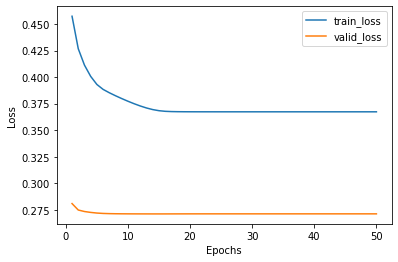

In [48]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [49]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    #ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    #ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta')
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta')
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [50]:
tstdl = DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [51]:
model.eval()

data_iter = iter(tstdl)

number of samples: 5
Neural Net Zeta:
tensor([0.9189, 0.9196, 0.9190, 0.9456, 0.8944, 0.9719, 0.9997, 1.0569, 1.0868,
        0.9724, 0.9998, 1.0861, 1.0565, 0.9453, 0.9988, 0.9713, 0.9976, 0.9418,
        0.9970, 0.8674, 0.9683, 0.9173, 0.9127, 0.9691, 1.1320, 1.0664, 1.1012,
        1.0362, 1.0128, 1.0366, 1.0137, 1.0423, 0.9843, 1.0709, 1.0135, 0.9857,
        0.9810, 1.0122, 1.0140, 1.0417, 0.9863, 1.0143, 1.1987, 1.1340, 1.0729,
        1.0150, 1.0151, 0.9874, 1.0154, 1.0155, 1.0156, 1.0157, 1.0444, 1.0157,
        1.0444, 1.0444, 0.9344, 0.9878, 1.1670, 1.1669, 1.0733, 1.0151, 1.0435,
        1.0147])
GLM Zeta:
tensor([1.2043, 1.2035, 1.2042, 1.0567, 1.3708, 0.9280, 0.8145, 0.6279, 0.5512,
        0.9277, 0.8145, 0.5515, 0.6281, 1.0570, 0.8151, 0.9284, 0.8159, 1.0600,
        0.8162, 1.5648, 0.9307, 1.2059, 1.2107, 0.9301, 0.6118, 0.7963, 0.6968,
        0.9076, 1.0297, 0.9073, 1.0290, 0.9035, 1.1735, 0.7937, 1.0292, 1.1722,
        1.1766, 1.0302, 1.0288, 0.9039, 1.1716, 1.0285,

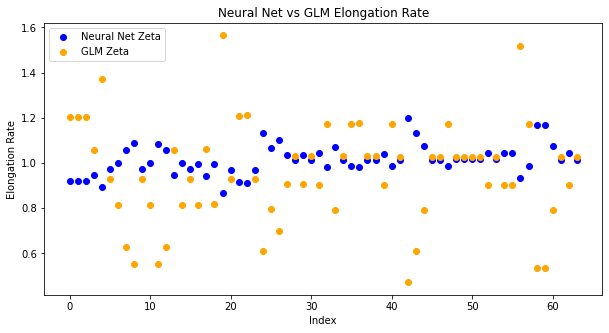

number of samples: 5
Neural Net Zeta:
tensor([1.0430, 1.0722, 0.9861, 0.9858, 1.0133, 1.0416, 0.9580, 0.9577, 1.1002,
        1.1956, 1.1306, 1.0114, 1.0111, 1.0988, 1.0392, 1.0105, 1.0388, 1.0387,
        1.0101, 1.0678, 0.9823, 1.0100, 1.0385, 0.9653, 0.9654, 0.9390, 0.9391,
        1.0210, 0.9395, 0.9139, 0.9664, 0.9666, 0.9669, 1.1631, 1.0409, 1.0126,
        1.0129, 1.0132, 1.0420, 1.0422, 1.0139, 1.0141, 1.0428, 0.9866, 1.0431,
        1.0146, 0.9868, 0.9869, 1.0727, 1.1660, 1.0146, 1.0145, 1.0143, 0.9863,
        1.0425, 1.0423, 0.9856, 0.9853, 0.9849, 1.0409, 0.9842, 0.9838, 1.0214,
        1.0210])
GLM Zeta:
tensor([0.9029, 0.7929, 1.1718, 1.1721, 1.0293, 0.9039, 1.3359, 1.3362, 0.6972,
        0.4720, 0.6124, 1.0309, 1.0311, 0.6979, 0.9055, 1.0315, 0.9058, 0.9059,
        1.0318, 0.7954, 1.1753, 1.0319, 0.9060, 0.9330, 0.9329, 1.0625, 1.0624,
        0.7189, 1.0621, 1.2095, 0.9321, 0.9319, 0.9318, 0.5375, 0.9044, 1.0299,
        1.0296, 1.0294, 0.9036, 0.9035, 1.0289, 1.0287,

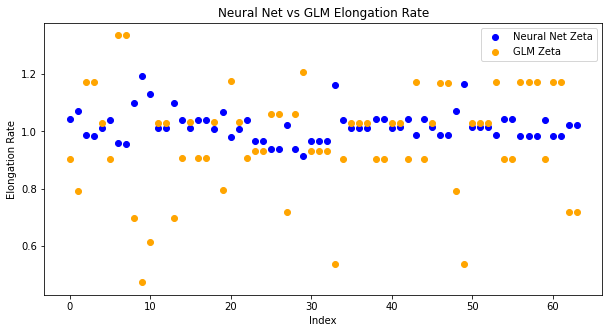

number of samples: 5
Neural Net Zeta:
tensor([0.9388, 0.9647, 0.9378, 0.8866, 0.9111, 0.9362, 0.9101, 0.9096, 0.8841,
        0.9086, 0.9081, 0.9077, 0.9329, 0.9588, 0.9585, 0.9581, 0.8812, 0.9313,
        0.9574, 0.9310, 0.9571, 0.9307, 0.9052, 0.9051, 0.9307, 0.9052, 0.8922,
        0.8439, 0.9426, 0.9414, 0.9396, 0.8387, 0.9093, 0.9324, 0.9301, 0.9541,
        0.9263, 0.8753, 0.9250, 1.0634, 0.9526, 0.9544, 0.9040, 0.8853, 0.8857,
        0.9367, 0.8863, 0.8623, 0.9399, 0.9404, 0.9674, 0.8903, 0.8903, 0.8901,
        0.8898, 0.8893, 0.9106, 0.8836, 0.9107, 1.0477, 0.9121, 0.9916, 0.8872,
        0.9915])
GLM Zeta:
tensor([1.0627, 0.9334, 1.0636, 1.3803, 1.2124, 1.0649, 1.2134, 1.2140, 1.3833,
        1.2150, 1.2154, 1.2159, 1.0679, 0.9379, 0.9382, 0.9384, 1.3869, 1.0693,
        0.9390, 1.0696, 0.9392, 1.0698, 1.2186, 1.2186, 1.0699, 1.2185, 1.1639,
        1.5138, 0.9087, 0.9268, 0.9531, 1.6600, 1.1673, 1.0663, 1.1078, 1.0065,
        1.1788, 1.5595, 1.2142, 0.6333, 1.0545, 1.0333,

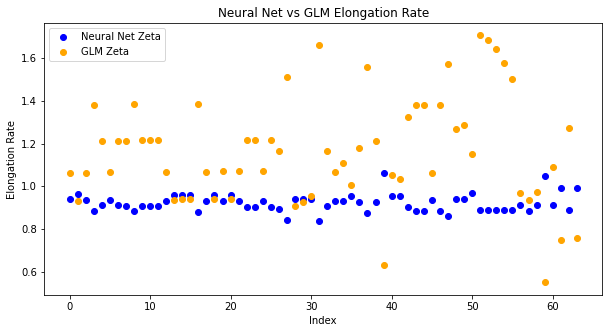

number of samples: 5
Neural Net Zeta:
tensor([0.9642, 1.0203, 0.9649, 0.8632, 0.9646, 0.9645, 0.9643, 0.9120, 0.9640,
        0.9375, 0.8866, 0.8865, 0.9371, 0.9371, 0.8863, 0.9369, 0.9112, 0.9904,
        0.8861, 0.8617, 0.9367, 0.9109, 0.9365, 0.8858, 0.8857, 1.0178, 0.9362,
        0.9361, 0.9102, 0.8851, 0.9099, 0.9354, 0.9096, 0.9094, 0.8365, 0.9091,
        0.9609, 0.8838, 0.8836, 0.9084, 0.8834, 0.9338, 0.8590, 0.9600, 0.9600,
        0.9600, 0.8833, 0.9602, 0.9340, 0.9606, 0.9608, 0.9347, 0.8845, 0.9097,
        0.9357, 0.9104, 0.9901, 0.9369, 0.9116, 0.8870, 0.9123, 0.9384, 0.9387,
        0.9390])
GLM Zeta:
tensor([0.8655, 0.7193, 0.9332, 1.5708, 0.9335, 0.9336, 0.9337, 1.2114, 0.9339,
        1.0638, 1.3802, 1.3803, 1.0641, 1.0642, 1.3806, 1.0643, 1.2123, 0.8205,
        1.3809, 1.5729, 1.0645, 1.2125, 1.0646, 1.3812, 1.3813, 0.7207, 1.0650,
        1.0651, 1.2132, 1.3820, 1.2136, 1.0656, 1.2139, 1.2141, 1.7942, 1.2145,
        0.9363, 1.3837, 1.3839, 1.2152, 1.3842, 1.0671,

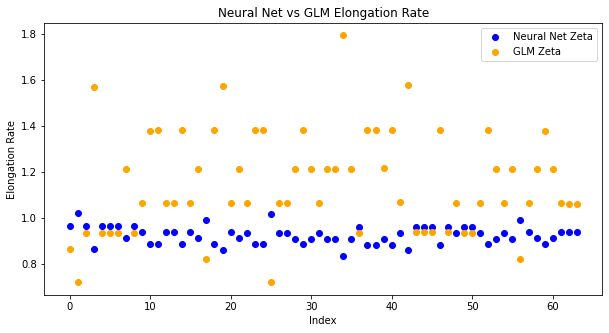

In [52]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    glm_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("Neural Net Zeta:")
    print(net_zeta)

    print("GLM Zeta:")
    print(glm_zeta)

    plot_data(glm_zeta, net_zeta)

In [53]:
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()))
        glm_zeta.append(batch['Z_ji'])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Correlation Coefficient: -0.7919430264345431
Mean Absolute Error: 0.3149
Mean Squared Error: 0.1893


In [54]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
        
    plt.plot([min(glm_zeta), max(glm_zeta)], [min(net_zeta), max(net_zeta)], color='red')  # Diagonal line
    
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [55]:
def scatterplot(net_zeta, glm_zeta, gene_id, log_scale, zoom):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    if zoom:
        plt.xlim(0.75, 1.25)
        plt.ylim(0.75, 1.25)
    else:
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
    
    if log_scale:
        ax.scatter(np.log(net_zeta), np.log(glm_zeta), s=5)        
    else:
        ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [56]:
def create_gene_id_mapping(dataset, indices):
    gene_id_map = {}
    for idx in indices:
        data = dataset[idx]
        gene_id = data['GeneId']

        if gene_id not in gene_id_map:
            gene_id_map[gene_id] = [idx]
        else:
            gene_id_map[gene_id].append(idx)

    return gene_id_map

test_dic = create_gene_id_mapping(dataset, test_idx)

number of samples: 3581


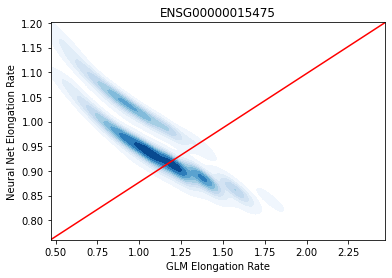

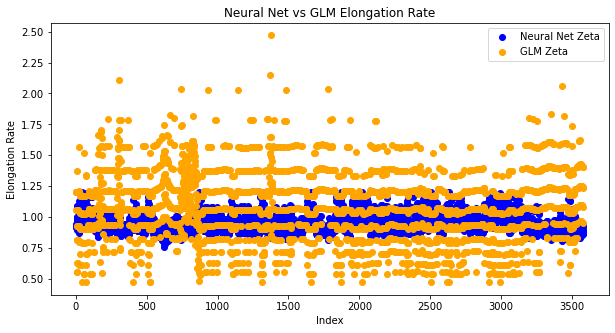

number of samples: 3184


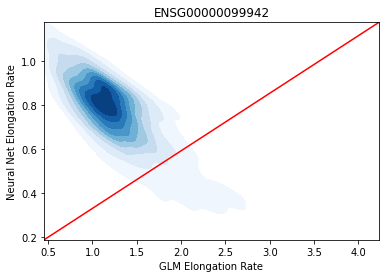

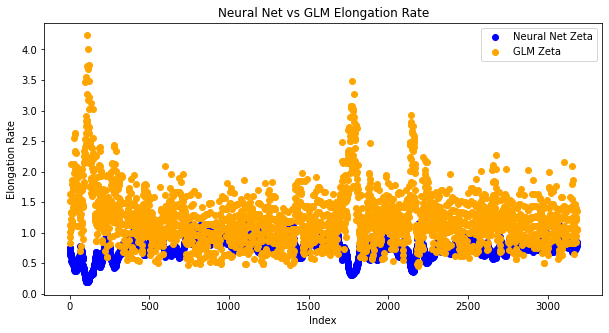

number of samples: 10864


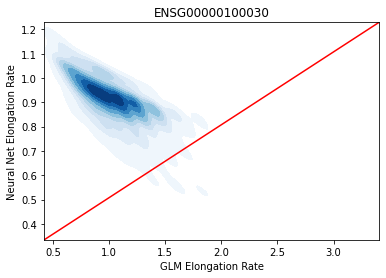

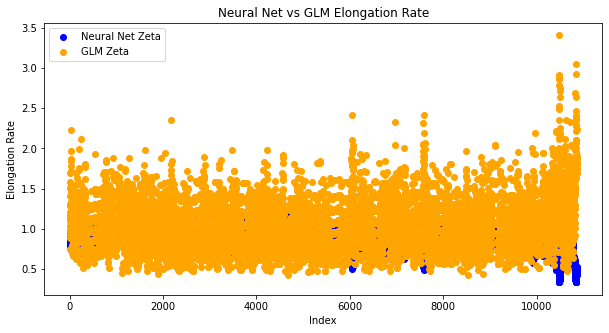

number of samples: 1097


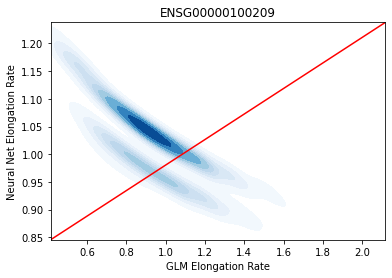

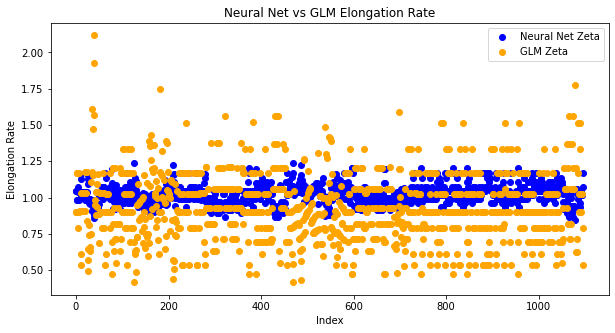

number of samples: 666


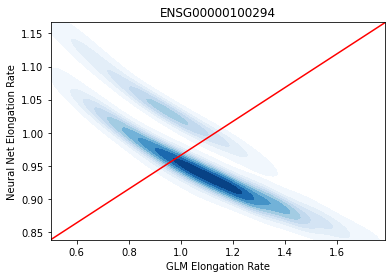

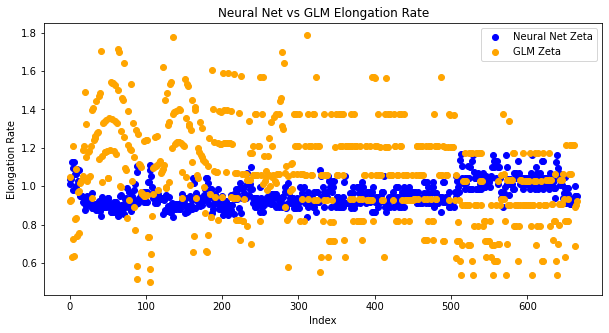

number of samples: 719


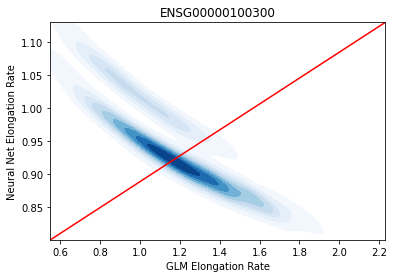

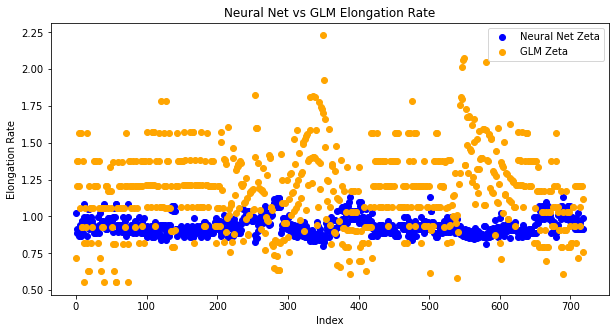

number of samples: 3143


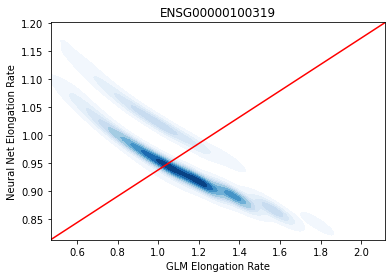

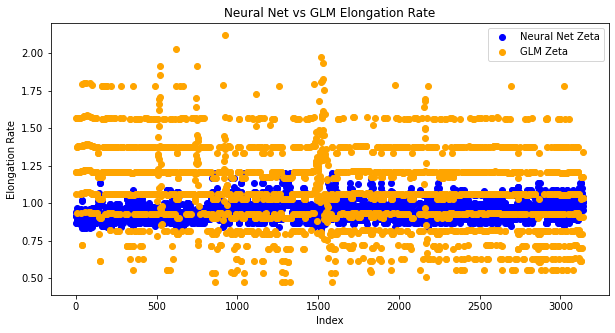

number of samples: 14319


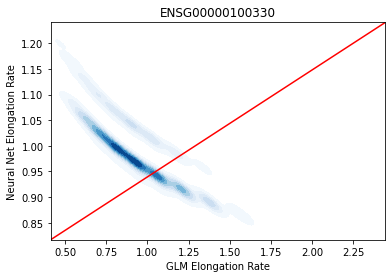

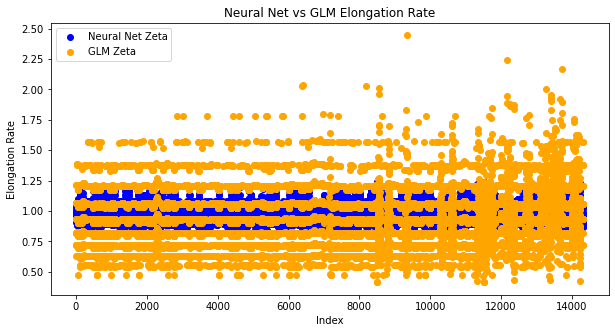

number of samples: 1712


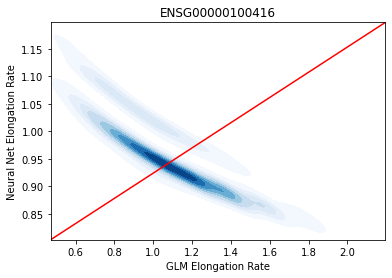

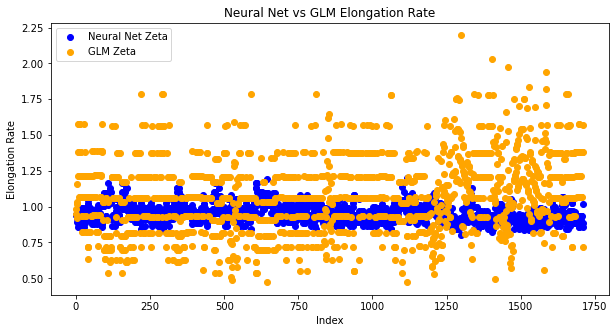

number of samples: 2711


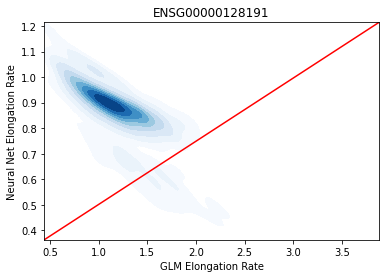

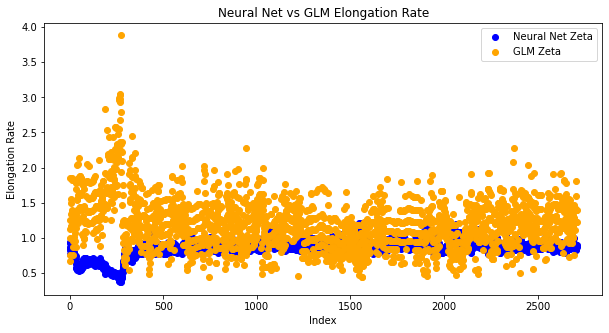

number of samples: 5179


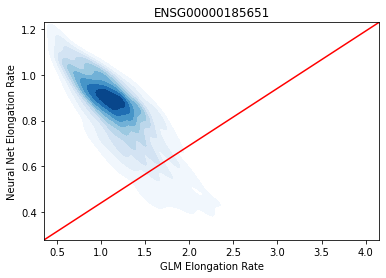

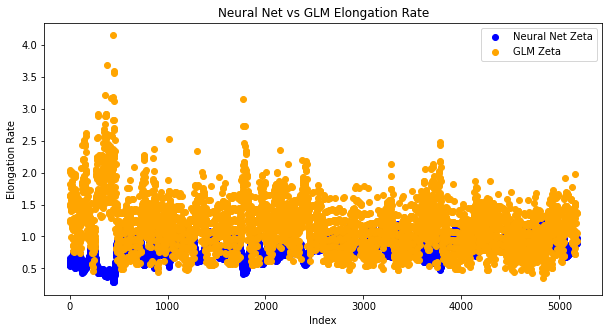

In [57]:
for gene_id, indices in test_dic.items():
    gene_id_subset = Subset(dataset, indices)
    test_loader = DataLoader(gene_id_subset, batch_size=len(indices))
    for batch in test_loader:
        model.eval()
        print("number of samples: " + str(len(indices)))

        with torch.no_grad():
            y_inputs = batch['Y_ji'].to(device)
            rho_ji = model(y_inputs)

        glm_zeta = batch['Z_ji']
        # convert log(Z) outputs to Z
        net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
        density_plot(glm_zeta, net_zeta, gene_id)
        
        #scatterplot(predicted_zeta, simulated_zeta, gene_id, False, False)
        
        plot_data(glm_zeta, net_zeta)
        